In [1]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs as ccrs
import xarray as xr
import numpy as np
from datetime import datetime
from holoviews import streams

In [2]:
import G5NR_utils


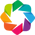

In [3]:
hv.notebook_extension('bokeh')

In [4]:
data_3d_full=xr.open_dataset('data_0_3D7km30minuteInst.nc')
data_2d_full=xr.open_dataset('data_1_inst30mn_2d_met1_Nx.nc')
data_2d=data_2d_full.isel(time=0)
#data_3d=G5NR_utils.load_from_zidv('remotepathtozidv')

In [5]:
data_3d=data_3d_full.isel(time=0)

In [6]:
regrid_3d=G5NR_utils.regrid(data_3d,90,45)
subrid_3d=G5NR_utils.subgrid(data_3d,90,45)
skedot_da=G5NR_utils.SKEDot(data_3d.airdens,data_3d.u,data_3d.v,data_3d.w,90,45)

In [7]:
up_img=gv.Dataset(subrid_3d.u).to(gv.Image,kdims=['lon','lat'],label='up',dynamic=True).redim.range(u=(-20,20))
vp_img=gv.Dataset(subrid_3d.v).to(gv.Image,kdims=['lon','lat'],label='vp',dynamic=True).redim.range(u=(-20,20))
wp_img=gv.Dataset(subrid_3d.v).to(gv.Image,kdims=['lon','lat'],label='wp',dynamic=True).redim.range(u=(-1,1))
#pr_img=gv.Dataset(data_2d.prectot*86400).to(gv.Image,kdims=['lon','lat'],label='prectot').redim.range(prectot=(0,24))

:Layout
   .DynamicMap.I   :DynamicMap   [lev]
   .DynamicMap.II  :DynamicMap   [lev]
   .DynamicMap.III :DynamicMap   [lev]
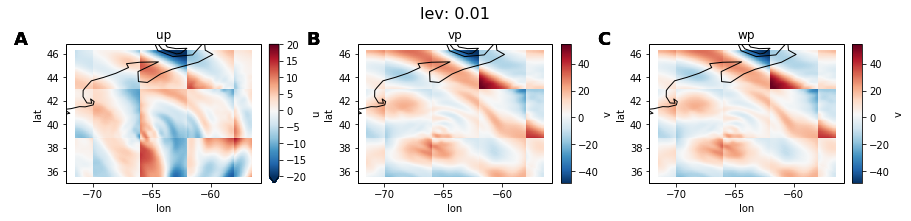

In [8]:
%%output backend='matplotlib'
%%opts Image (cmap='RdBu_r') [colorbar=True]
#%%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True toolbar='above'] #for bokeh
up_img*gf.coastline + vp_img*gf.coastline + wp_img*gf.coastline

In [9]:
%%output backend='bokeh'
%%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True xaxis=None, yaxis=None toolbar='above']
(up_img*gf.coastline + vp_img*gf.coastline + wp_img*gf.coastline).cols(2)

:Layout
   .DynamicMap.Up :DynamicMap   [lev]
   .DynamicMap.Vp :DynamicMap   [lev]
   .DynamicMap.Wp :DynamicMap   [lev]

In [10]:
def u_plots(x,y):
    lon=x
    lat=y
    lvs=regrid_3d.u.sel(lat=lat,lon=lon,method='nearest').lev.values
    u=regrid_3d.u.sel(lat=lat,lon=lon,method='nearest').values
    upwp=skedot_da.upwp.sel(lat=lat,lon=lon,method='nearest').values
    uw=skedot_da.uw.sel(lat=lat,lon=lon,method='nearest').values
    udiv=skedot_da.Eddy_Tend_Zon.sel(lat=lat,lon=lon,method='nearest').values
    usheardiv=skedot_da.Eddy_Tend_Zon.sel(lat=lat,lon=lon,method='nearest').values*skedot_da.ushear.isel(lat=0,lon=0).values
    ubaro=skedot_da.ubaro.sel(lat=lat,lon=lon,method='nearest').values

    rho=regrid_3d.airdens.sel(lat=lat,lon=lon,method='nearest').values
    usheardiv_mean=np.nansum(usheardiv*rho)/np.nansum(rho)

    dp=lvs*100
    dpbyg=np.gradient(dp)/9.8
    skedot_zon=np.nansum(usheardiv*dpbyg)

    u_curve=hv.Curve((u, lvs), kdims=['U'], vdims=['pressure']).redim.range(pressure=(1000,0))
    u_curve=u_curve*hv.VLine(float(ubaro),label='ubaro')(style={'color':'black'})

    upwp_curve=hv.Curve((upwp, lvs), kdims=['UPWP[blue]-UW[red]'], vdims=['pressure']).redim.range(pressure=(1000,0))
    upwp_curve=upwp_curve*hv.Curve((uw,lvs),kdims=['UW[red]'],vdims=['pressure']).redim.range(pressure=(1000,0))

    udiv_curve=hv.Curve((udiv, lvs), kdims=['div(rhoupwp)'], vdims=['pressure']).redim.range(pressure=(1000,0))

    usheardiv_curve=hv.Curve((usheardiv, lvs), kdims=['div*ushear[skedot_zon='+format(skedot_zon,"0.2f")+']'], vdims=['pressure']).redim.range(pressure=(1000,0))
    usheardiv_curve=usheardiv_curve*hv.VLine(float(usheardiv_mean),label='umean')(style={'color':'black'})
    return (upwp_curve+udiv_curve+u_curve+usheardiv_curve)
    

In [11]:
def v_plots(x,y):
    lon=x
    lat=y
    lvs=regrid_3d.v.sel(lat=lat,lon=lon,method='nearest').lev.values
    v=regrid_3d.v.sel(lat=lat,lon=lon,method='nearest').values
    vpwp=skedot_da.vpwp.sel(lat=lat,lon=lon,method='nearest').values
    vw=skedot_da.vw.sel(lat=lat,lon=lon,method='nearest').values
    vdiv=skedot_da.Eddy_Tend_Mer.sel(lat=lat,lon=lon,method='nearest').values
    vsheardiv=skedot_da.Eddy_Tend_Mer.sel(lat=lat,lon=lon,method='nearest').values*skedot_da.vshear.isel(lat=0,lon=0).values
    vbaro=skedot_da.vbaro.sel(lat=lat,lon=lon,method='nearest').values

    dp=lvs*100
    dpbyg=np.gradient(dp)/9.8
    skedot_mer=np.nansum(vsheardiv*dpbyg)

    rho=regrid_3d.airdens.sel(lat=lat,lon=lon,method='nearest').values
    vsheardiv_mean=np.nansum(vsheardiv*rho)/np.nansum(rho)


    v_curve=hv.Curve((v, lvs), kdims=['V'], vdims=['pressure']).redim.range(pressure=(1000,0))
    v_curve=v_curve*hv.VLine(float(vbaro),label='vbaro')(style={'color':'black'})

    vpwp_curve=hv.Curve((vpwp, lvs), kdims=['VPWP[blue]-UW[red]'], vdims=['pressure']).redim.range(pressure=(1000,0))
    vpwp_curve=vpwp_curve*hv.Curve((vw,lvs),kdims=['UW[red]'],vdims=['pressure']).redim.range(pressure=(1000,0))

    vdiv_curve=hv.Curve((vdiv, lvs), kdims=['div(rhovpwp)'], vdims=['pressure']).redim.range(pressure=(1000,0))

    vsheardiv_curve=hv.Curve((vsheardiv, lvs), kdims=['div*vshear[skedot_mer='+format(skedot_mer,"0.2f")+']'], vdims=['pressure']).redim.range(pressure=(1000,0))
    vsheardiv_curve=vsheardiv_curve*hv.VLine(float(vsheardiv_mean),label='vbaro')(style={'color':'black'})
    return (vpwp_curve+vdiv_curve+v_curve+vsheardiv_curve)

In [12]:
def uv_plots(x,y):
    return u_plots(x,y)+v_plots(x,y)

In [18]:
%%opts Image (cmap='RdBu_r') [width=600 height=400 colorbar=True toolbar='above' tools=['tap']]
skedot_img=hv.Image(skedot_da.SKEDOT,kdims=['lon','lat']).redim.range(SKEDOT=(-1,1))
tap=streams.SingleTap(source=skedot_img,x=regrid_3d.lon.values[0],y=regrid_3d.lat.values[0])
pointer=streams.PointerXY(source=skedot_img,x=regrid_3d.lon.values[0],y=regrid_3d.lat.values[0])
pointer_map=hv.DynamicMap(lambda x,y: hv.Points([(x,y)])(style={'size':10,'color':'black'}),streams=[pointer])

In [19]:
u_dyn_plot=hv.DynamicMap(u_plots,kdims=[],streams=[tap])
v_dyn_plot=hv.DynamicMap(v_plots,kdims=[],streams=[tap])
uv_dyn_plot=hv.DynamicMap(uv_plots,kdims=[],streams=[tap])

In [20]:
skedot_img*pointer_map

:DynamicMap   []

In [21]:
%%opts Curve [show_grid=True]
u_dyn_plot

:DynamicMap   []

In [16]:
%%opts Curve [show_grid=True]
uv_dyn_plot

:DynamicMap   []